# Automated Process Mining 
## using pm4py and pyspark

####  `pmpipelines vs.0.1.2` <font color="red"> <-- vs. NEEDS TO BE UPDATED AT EACH CODE COMMIT CHANGE!</font>

#### <font color="red">^__IMPORTANT! </font>
* (code versioning schema: **vs.Major.Minor.Patch**) 

Below are the libraries and APIs to be used.

- `pickle` for object (de)serialization
- `pyspark` spark API in Python
- `pm4py` an open source process mining python library
- `matplotlib` an open source library for plotting

### 1) Start Neo4j with: `$ neo4j start`
### 2) Connect to Neo4j

In [1]:
host="bolt://localhost:7687"
user="neo4j"
password="test"

### Import the correct Neo4J connector .jar _BEFORE_ starting the Spark session & initializing the `SparkContext`

In [2]:
import os
# [NOTE] change the appropriate directory path for the Neo4j connector .jar:
# import NEO4J .jar CONNECTOR FOR PYSPARK/SPARK vs.2
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars file:///usr/local/Cellar/apache-spark@2.4.6/2.4.6/libexec/jars/neo4j-connector-apache-spark_2.11-4.0.0.jar pyspark-shell'

In [3]:
import sys
import pickle
import time
import os
from string import Template

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import graphviz
from graphviz import Digraph 

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import udf, broadcast, col, lag, lead, unix_timestamp, collect_set, collect_list, explode, row_number, array_contains, monotonically_increasing_id, size, split, lit, map_concat, map_from_arrays, map_keys, map_values, map_from_entries, struct
from pyspark.sql.types import StringType, IntegerType, LongType, StructType, StructField, MapType, ArrayType, ByteType, TimestampType

from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator

`directSuccessionFrequency` is an RDD transformation that is used to transform records into the following form:

`ACTIVITY_1 [ 
    [Predecessor1, Frequency1] .. [PredecessorN, FreqencyN], 
    [Successor1, Frequency1] .. [SuccessorN, FreqencyN],
]`

**Such that: `( Predecessor {1,} )->(Activity)->( Successor{0,} )`**

In [4]:
preparationStartTime = time.time()

In [5]:
def directSuccessionFrequency(record):
    predecessorSet = set(record[1])
    successorSet = set(record[2])
    
    predecessorOutput = []
    successorOutput = []
    
    for item in predecessorSet:
        predecessorOutput.append(tuple([item, record[1].count(item)]))
        
    for item in successorSet:
        successorOutput.append(tuple([item, record[2].count(item)]))
    
    return (record[0], predecessorOutput, successorOutput)

## ===========
## Spark Session
</br>

#### <font color='red'> only in MAC OS! --> re-create the `/private/tmp/spark-events` directory </font> via `$ mkdir` command

Configuring spark in order to handle real big data.

- `spark.executor.memory`: is the memory amount required for executing the tasks (heap size)


- `spark.executor.cores`: is the number of tasks that can be running at the same time by the same executor


- `spark.executor.instances`: is the number of the executors on the worker


- `spark.driver.memory`: is the memory amount to maintain for the driver to receive the data


- `spark.eventLog.enabled`: is to enable the log history for the job for monitoring


- `spark.driver.maxResultSize`: is the total size of serialized result
- `spark.sql.execution.arrow.maxRecordsPerBatch`: max number of rows for each Arrow record batch (def. 10K/batch)

In [6]:
conf=SparkConf()
# [NOTE] the present configs are matching a dual-core i5 PC. Reset the specs for your PC.
# [NOTE] adding a custom partitions number to override the Spark default n.200
conf.set("spark.sql.shuffle.partitions", "10") # default 200
conf.set("spark.executor.memory","4g") # originally: 10g
conf.set("spark.executor.cores", "2") # originally: 10
conf.set("spark.executor.instances", "10")
conf.set("spark.driver.memory", "4g") # originally: 13g
conf.set("spark.eventLog.enabled", "true")
conf.set("spark.driver.maxResultSize", "4g") # originally: 15g

### `[NOT NEEDED ANYMORE]` Setting the schema manually to improve the read time instead of inferring the schema from the data.

In [7]:
# Creating/Starting the Spark Session:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# [NOTE] DATA SCHEMA NOT NEEDED ANYMORE

22/03/29 15:14:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### `[NOTE]` Check link for Spark running instance + refresh the browser to see the performance indicators: 
* browse Spark Jobs at `[LINK]` [http://172.17.37.79:4040/jobs/](http://172.17.37.79:4040/jobs/)

In [8]:
# [NOTE] re-set the appropriate directory path for the file:
new_log = spark.read.csv("data/BPIC15_1.csv", header=True)

### Renaming the columns to the namings that the miners understand

In [9]:
new_log = new_log.withColumnRenamed("org:resource", "Resource")\
        .withColumnRenamed("activityNameEN", "Activity")\
        .withColumnRenamed("case:concept:name", "Case ID")\
        .withColumnRenamed("concept:name", "Event ID")\
        .withColumnRenamed("time:timestamp", "Timestamp")\
        .withColumn("Costs", lit(1))

In [10]:
new_log = new_log.select('Case ID', 'Event ID', 'Timestamp', 'Activity', 'Resource', 'Costs')

In [11]:
# rdd_log = spark.read.csv("./alpha_miner.csv", header=True, sep=',', schema=schema)
new_ts_schema = 'yyyy-MM-dd HH:mm:ss'
old_ts_schema = 'dd-MM-yyyy:HH.mm'
new_log = new_log.withColumn("Timestamp", unix_timestamp(new_log['Timestamp'], new_ts_schema))

In [12]:
df = new_log

### 1) Partitioning and windowing by 'Case ID', then sorting by, i.e., `.orderBy`,  _timestamp_ ascendingly

### 2) Calculating the _predecessor_ and _successor_ for each activity by using `lag` for predecessor and `lead` for predecessor

In [13]:
directSuccessionWindow = Window.partitionBy("Case ID").orderBy("Timestamp")

In [14]:
df = df.withColumn("predecessor",lag("Activity",1).over(directSuccessionWindow))
df = df.withColumn("successor",lead("Activity",1).over(directSuccessionWindow))

In [15]:
direct_succession_freq = df.select("activity", "predecessor", "successor").groupby("activity").agg(collect_list("predecessor").alias("predecessor"), collect_list("successor").alias("successor"))
direct_succession = df.select("activity", "predecessor", "successor").groupby("activity").agg(collect_set("predecessor").alias("predecessor"), collect_set("successor").alias("successor"))

### Then after finding the _predecessor_ and _successor_, use the `directSuccessionFrequency` transformer in order to transform the record into the format mentioned in the documentation of the transformer (above)

In [16]:
direct_succession_freq = direct_succession_freq.rdd.map(directSuccessionFrequency).toDF(["activity", "predecessor", "successor"])

In [17]:
activities = direct_succession_freq.select('activity')

### Settings for Neo4j connection/query

In [18]:
activities_result = activities.write.format("org.neo4j.spark.DataSource") \
    .option("url", host) \
    .option("authentication.type", "basic") \
    .option("authentication.basic.username", user) \
    .option("authentication.basic.password", password) \
    .option("query", "MERGE (p:Activity {name: event.activity})") \
    .save()

In [19]:
activities_successors = df.select('activity', 'successor', 'Costs').na.fill("---")

In [20]:
activities_successors_grouped = activities_successors.groupby("activity", "successor").sum('Costs').withColumnRenamed('sum(Costs)', 'cost')

In [21]:
# WRITE query for Neo4j
activities_successors_result = activities_successors_grouped.repartition(1).write.format("org.neo4j.spark.DataSource") \
    .option("url", host) \
    .option("authentication.type", "basic") \
    .option("authentication.basic.username", user) \
    .option("authentication.basic.password", password) \
    .option("query", '''
        MATCH (p:Activity {name: event.activity})
        MATCH (c:Activity {name: event.successor})
        MERGE (p)-[r:PRODUCES {cost: event.cost}]->(c)
        ''') \
    .save()

22/03/29 15:51:01 WARN Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


### Creating the query from the generated transformation, thus will be used in Neo4j to generate the DFG on that side

### The same query is used for incremental updates over the DFG that was stored in Neo4j

### Check link for the Neo4j running instance: 
* browse at `[LINK]` [http://localhost:7474](http://localhost:7474)

### Sending the _creation_ query to Neo4j

In [22]:
preparationExecutionTime = time.time() - preparationStartTime

dfgAlgorithmsStart = time.time()

### Below is the query that gets the DFG

In [23]:
readQuery = "MATCH result=(p:Activity)-[r:PRODUCES]->(c:Activity) RETURN p.name as Parent, c.name as Child, r.cost as Frequency"

## `[NOTE]` The next cell code is one of the biggest performance bottlenecks in the process
### now it runs on $x$ (e.g., `conf.set("spark.sql.shuffle.partitions", "10")`)  data partitions, instead of the initial  standard Spark set of
* $partitions=200$

In [24]:
# READ query for Neo4j
df = spark.read.format("org.neo4j.spark.DataSource") \
    .option("url", host) \
    .option("authentication.type", "basic") \
    .option("authentication.basic.username", user) \
    .option("authentication.basic.password", password) \
    .option("query", readQuery) \
    .load()

### `[NOTE]` (if needed) to delete the created Neo4j database:

`MATCH (n)
OPTIONAL MATCH (n)-[r]-()
delete n, r`

### Converting the DFG that was fetched from Neo4j to the *format* that PM4py used to understand

```
{
    (Parent_1, Child_1): Frequency_1,
    (Parent_2, Child_2): Frequency_2
}

```

In [25]:
def flattenDFG(dfg):
    mydict = {}
    for item in dfg:
        mydict.update(item)
    return mydict

flatten_dfg = udf(lambda dfg: flattenDFG(dfg), MapType(StructType([StructField("parent", StringType(), True), StructField("child", StringType(), True)]), IntegerType()))

def getDFG(p,c,f):
    return {(p,c):f}

get_dfg = udf(lambda p,c,f: getDFG(p,c,f), MapType(StructType([StructField("parent", StringType(), True), StructField("child", StringType(), True)]), IntegerType()))

### Preparing the UDFs for each PM miner algorithm

**Each UDF takes the DFG as input and returns a *pickled object* representing the net**

*By this approach, we are able to store a different type of object rather than the primitives in pySpark.*

In [26]:
def alphaMiner(dfg):
    net, initial_marking, final_marking = alpha_miner.apply_dfg(dfg)
    return str(pickle.dumps({'net': net, 'im': initial_marking, 'fm': final_marking}), encoding="latin1")

def heuristicMiner(dfg, threshold):
    net, im, fm = heuristics_miner.apply_dfg(dfg, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: threshold})
    return str(pickle.dumps({'net': net, 'im': im, 'fm': fm}), encoding="latin1")

def inductiveMiner(dfg, threshold):
    net, im, fm = inductive_miner.apply_dfg(dfg, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: threshold})
    return str(pickle.dumps({'net': net, 'im': im, 'fm': fm}), encoding="latin1")

alpha_miner_alg = udf(lambda dfg: alphaMiner(dfg))
heuristic_miner_alg = udf(lambda dfg, threshold: heuristicMiner(dfg, threshold))
inductive_miner_alg = udf(lambda dfg, threshold: inductiveMiner(dfg, threshold))

### Getting the DFG that will be passed to each miner in parallel

In [27]:
DFG = df.withColumn("dfg", get_dfg(df.Parent, df.Child, df.Frequency)).withColumn("threshold", lit(0.99))

In [28]:
# DFG.toPandas()
DFG = DFG.agg(collect_list('dfg').alias('dfg')).withColumn("dfg", flatten_dfg("dfg")).withColumn("threshold", lit(0.99))

### Calling each miner with different miner algorithms on the same DFG

In [29]:
# alphaMinerDF = DFG.withColumn("petrinet", alpha_miner_alg("dfg"))

heuristicMinerDF = DFG.withColumn("petrinet", heuristic_miner_alg("dfg", "threshold"))
inductiveMinerDF = DFG.withColumn("petrinet", inductive_miner_alg("dfg", "threshold"))

In [30]:
dfgAlgorithmsExecutionTime = time.time() - dfgAlgorithmsStart

evaluationStartTime = time.time()

In [31]:
new_log = new_log.withColumn("concept:name", col("Activity")).withColumnRenamed("Case ID", "case:concept:name").withColumnRenamed("Timestamp", "time:timestamp")

### Selecting the _Petri net_ object from the dataframe of each algorithm in order to run evaluators on top of it

In [33]:
# alphaMinerNet = alphaMinerDF.select('petrinet').collect()[0][0]
heuristicMinerNet = heuristicMinerDF.select('petrinet').collect()[0][0]
inductiveMinerNet = inductiveMinerDF.select('petrinet').collect()[0][0]

### Deserializing the extracted _Petri net_ object of each algorithm in order to be used for evaluators

In [34]:
# alphapn = pickle.loads(bytes(alphaMinerNet, "latin1"))
heuristicpn = pickle.loads(bytes(heuristicMinerNet, "latin1"))
inductivepn = pickle.loads(bytes(inductiveMinerNet, "latin1"))

### Converting the RDD to Pandas
### Converting the grouped (simplified) RDD to Pandas

#### This is primarily done because of the current implementation of the evaluators require the log to be in Pandas format

In [35]:
new_log.columns

['case:concept:name',
 'Event ID',
 'time:timestamp',
 'Activity',
 'Resource',
 'Costs',
 'concept:name']

In [37]:
# pandas_rdd = new_log.toPandas()
## reset the path to the .csv files by your own directory path
merged_rdd = spark.read.csv("merged-data/merged_1_2_3_4_5.csv", header=True)
merged_rdd = merged_rdd.withColumnRenamed("org:resource", "Resource")\
        .withColumnRenamed("activityNameEN", "Activity")\
        .withColumn("Costs", lit(1))

merged_rdd = merged_rdd.select('case:concept:name', 'concept:name', 'time:timestamp', 'Activity', 'Resource', 'Costs')

merged_rdd = merged_rdd.withColumn("time:timestamp", unix_timestamp(merged_rdd['time:timestamp'], new_ts_schema))
pandas_rdd = merged_rdd.toPandas()

In [ ]:
# merged_rdd.columns

### Calculating the evaluation metrics over each _Petri net_ object

- Simplicity
- Fitness
- Precision
- Generalization

***And eventually summing up all of the values for all evaluators and labeling it as the score***

In [38]:
def getEvaluationMetrics(pandasRdd, petrinetObject):
    simplicity = simplicity_evaluator.apply(petrinetObject['net'])
    fitness = replay_fitness_evaluator.apply(pandasRdd, petrinetObject['net'], petrinetObject['im'], petrinetObject['fm'], variant=replay_fitness_evaluator.Variants.TOKEN_BASED)["log_fitness"]
    precision = precision_evaluator.apply(pandasRdd, petrinetObject['net'], petrinetObject['im'], petrinetObject['fm'], variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
    generalization = generalization_evaluator.apply(pandasRdd, petrinetObject['net'], petrinetObject['im'], petrinetObject['fm'])
    
    return {"simplicity" : simplicity, 
            "fitness": fitness, 
            "precision": precision, 
            "generalization": generalization,
            "score": simplicity+fitness+precision+generalization
           }

In [ ]:
print("Alpha Miner Score")
# alphaMinerEvaluation = getEvaluationMetrics(pandas_rdd, alphapn)

In [39]:
print("Hueristic Miner Score")
heuristicMinerEvaluation = getEvaluationMetrics(pandas_rdd, heuristicpn)

Hueristic Miner Score


replaying log with TBR, completed variants ::   0%|          | 0/5539 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/188753 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5539 [00:00<?, ?it/s]

In [40]:
print("Inductive Miner Score")
inductiveMinerEvaluation = getEvaluationMetrics(pandas_rdd, inductivepn)

Inductive Miner Score


replaying log with TBR, completed variants ::   0%|          | 0/5539 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/188753 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5539 [00:00<?, ?it/s]

In [41]:
evaluationExecutionTime = time.time() - evaluationStartTime

In [42]:
print(evaluationExecutionTime)
print(evaluationStartTime)

10224.329345941544
1648561487.29927


In [43]:
print(dfgAlgorithmsExecutionTime)
print(dfgAlgorithmsStart)

2224.016847848892
1648559263.282318


In [44]:
print(preparationExecutionTime)
print(preparationStartTime)

3564.3040640354156
1648555698.9782069


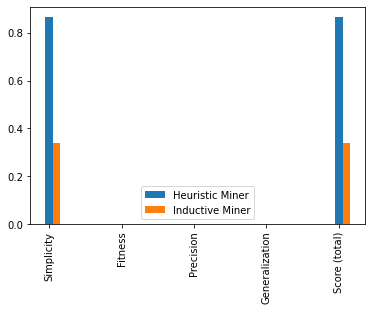

In [45]:
labels = ['Simplicity', 'Fitness', 'Precision', 'Generalization', 'Score (total)']
# alpha_means = [
#     alphaMinerEvaluation['simplicity'], 
#     alphaMinerEvaluation['fitness'], 
#     alphaMinerEvaluation['precision'], 
#     alphaMinerEvaluation['generalization'],
#     alphaMinerEvaluation['score']
# ]
heuristic_means = [
    heuristicMinerEvaluation['simplicity'], 
    heuristicMinerEvaluation['fitness'], 
    heuristicMinerEvaluation['precision'], 
    heuristicMinerEvaluation['generalization'],
    heuristicMinerEvaluation['score']
]
inductive_means = [
    inductiveMinerEvaluation['simplicity'], 
    inductiveMinerEvaluation['fitness'], 
    inductiveMinerEvaluation['precision'], 
    inductiveMinerEvaluation['generalization'],
    inductiveMinerEvaluation['score']
]

Pos = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

# plt.bar(Pos - width, alpha_means, width = width, label = 'Alpha Miner')
plt.bar(Pos, heuristic_means, width = width, label = 'Heuristic Miner')
plt.bar(Pos + width, inductive_means, width = width, label = 'Inductive Miner')

plt.xticks(range(len(labels)), labels, rotation=90)

plt.legend()
plt.show()

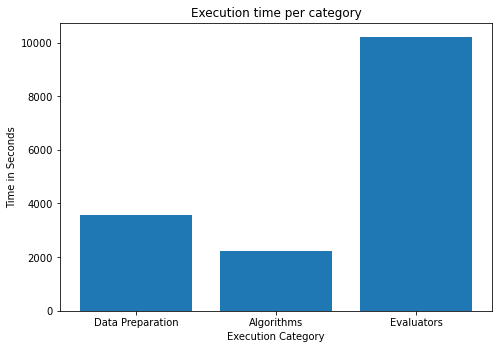

In [46]:
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
ax.set_title('Execution time per category')
ax.set_ylabel('Time in Seconds')
ax.set_xlabel('Execution Category')
labels = ['Data Preparation', 'Algorithms', 'Evaluators']
values = [preparationExecutionTime, dfgAlgorithmsExecutionTime, evaluationExecutionTime]
ax.bar(labels,values)
plt.show()

<font color="red">**^_**`[NOTE]`**_REFACTORED UP TO THIS POINT**</font>